# Intro

- This notebook is intended to explore the data and check the baseline performance of the models XGBoost and Random Forest for both binary and multiclass classification
- It will be a starting point and reference for further data processing pipelines and model training.

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import mlflow


import sys
sys.path.append("..")

from src.utils.metrics import get_metrics_binary, get_metrics_multiclass

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("0_prototyping")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1754040659577, experiment_id='1', last_update_time=1754040659577, lifecycle_stage='active', name='0_prototyping', tags={}>

# Load data

In [2]:
file_path = "../data/raw/DNN-EdgeIIoT-dataset.csv"

In [3]:
df = pd.read_csv(file_path, low_memory=False)

In [4]:
df.shape

(2219201, 63)

In [5]:
df.head()

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,2021 11:44:10.081753000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,2021 11:44:10.162218000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,2021 11:44:10.162271000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,2021 11:44:10.162641000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,2021 11:44:10.166132000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal


# Data exploration and processing

In [6]:
# Check for missing values
df.isna().sum()

frame.time            0
ip.src_host           0
ip.dst_host           0
arp.dst.proto_ipv4    0
arp.opcode            0
                     ..
mbtcp.len             0
mbtcp.trans_id        0
mbtcp.unit_id         0
Attack_label          0
Attack_type           0
Length: 63, dtype: int64

In [7]:
# Check for duplicate rows
df.duplicated().sum()

np.int64(815)

In [8]:
# Drop duplicate rows
df.drop_duplicates(subset=None, keep="first", inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(2218386, 63)

In [9]:
# Check the cardinality of features
df.nunique()

frame.time            2206364
ip.src_host            137167
ip.dst_host             52425
arp.dst.proto_ipv4          9
arp.opcode                  3
                       ...   
mbtcp.len                   8
mbtcp.trans_id            151
mbtcp.unit_id               6
Attack_label                2
Attack_type                15
Length: 63, dtype: int64

In [10]:
# Drop columns with only one unique value
cols_one_unique_val = df.nunique()[df.nunique() == 1].index.tolist()
df.drop(columns=cols_one_unique_val, inplace=True)
df.shape

(2218386, 59)

In [11]:
df.columns

Index(['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
       'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'icmp.checksum',
       'icmp.seq_le', 'icmp.transmit_timestamp', 'http.file_data',
       'http.content_length', 'http.request.uri.query', 'http.request.method',
       'http.referer', 'http.request.full_uri', 'http.request.version',
       'http.response', 'tcp.ack', 'tcp.ack_raw', 'tcp.checksum',
       'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn',
       'tcp.connection.synack', 'tcp.dstport', 'tcp.flags', 'tcp.flags.ack',
       'tcp.len', 'tcp.options', 'tcp.payload', 'tcp.seq', 'tcp.srcport',
       'udp.port', 'udp.stream', 'udp.time_delta', 'dns.qry.name',
       'dns.qry.name.len', 'dns.qry.qu', 'dns.retransmission',
       'dns.retransmit_request', 'dns.retransmit_request_in',
       'mqtt.conack.flags', 'mqtt.conflag.cleansess', 'mqtt.conflags',
       'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg', 'mqtt.msgtype',
       'mqtt.prot

In [12]:
# Drop timestamps; drop IP addresses and ports for better generalization
df.drop(
    columns=[
        "frame.time", "icmp.transmit_timestamp", "ip.src_host", "ip.dst_host",
        "arp.src.proto_ipv4", "arp.dst.proto_ipv4", "tcp.srcport", "tcp.dstport",
        "udp.port"
    ],
    inplace=True
)
df.shape

(2218386, 50)

In [13]:
# Additional features to drop: not useful for classification or way too complex
# (e.g., large text fields, complex structures, noise)
df = df.drop(
    columns=[
        "http.file_data", "http.request.uri.query", "http.request.full_uri",
        "tcp.payload", "tcp.options", "mqtt.msg"
    ]
)
df.shape

(2218386, 44)

In [14]:
df.head()

,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,http.content_length,http.request.method,http.referer,http.request.version,http.response,tcp.ack,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal


In [15]:
# Check data types of features
df.dtypes

arp.opcode                   float64
arp.hw.size                  float64
icmp.checksum                float64
icmp.seq_le                  float64
http.content_length          float64
http.request.method           object
http.referer                  object
http.request.version          object
http.response                float64
tcp.ack                      float64
tcp.ack_raw                  float64
tcp.checksum                 float64
tcp.connection.fin           float64
tcp.connection.rst           float64
tcp.connection.syn           float64
tcp.connection.synack        float64
tcp.flags                    float64
tcp.flags.ack                float64
tcp.len                      float64
tcp.seq                      float64
udp.stream                   float64
udp.time_delta               float64
dns.qry.name                 float64
dns.qry.name.len              object
dns.qry.qu                   float64
dns.retransmission           float64
dns.retransmit_request       float64
d

# Check class distribution

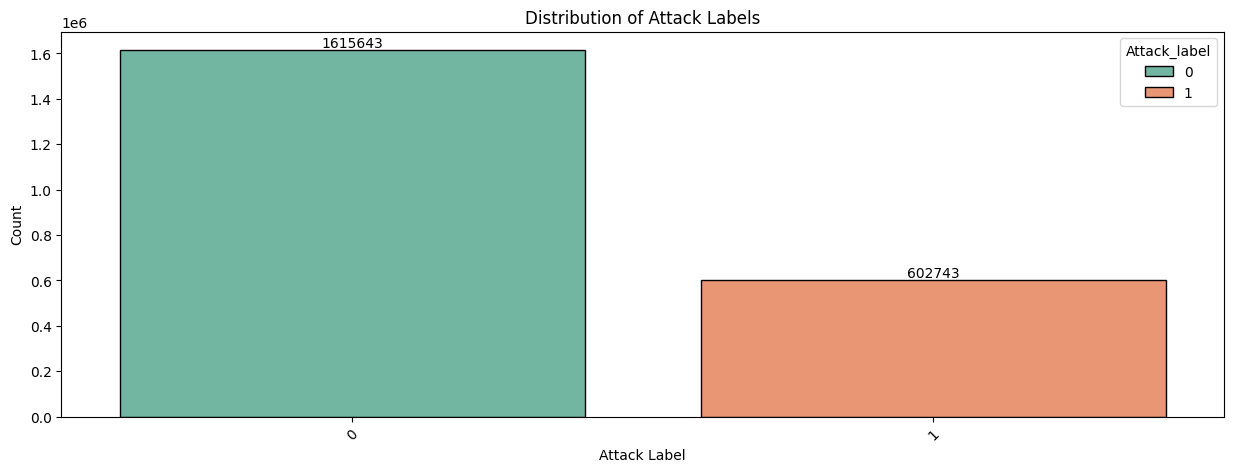

In [16]:
vc_labels = df["Attack_label"].value_counts()
plt.figure(figsize=(15, 5))
sns.barplot(
    x=vc_labels.index,
    y=vc_labels.values,
    hue=vc_labels.index, palette="Set2",
    edgecolor="black"
)
for label in vc_labels.index:
    plt.text(
        x=label, 
        y=vc_labels[label] + 5,
        s=str(vc_labels[label]),
        ha='center', va='bottom'
    )
plt.title("Distribution of Attack Labels")
plt.xlabel("Attack Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

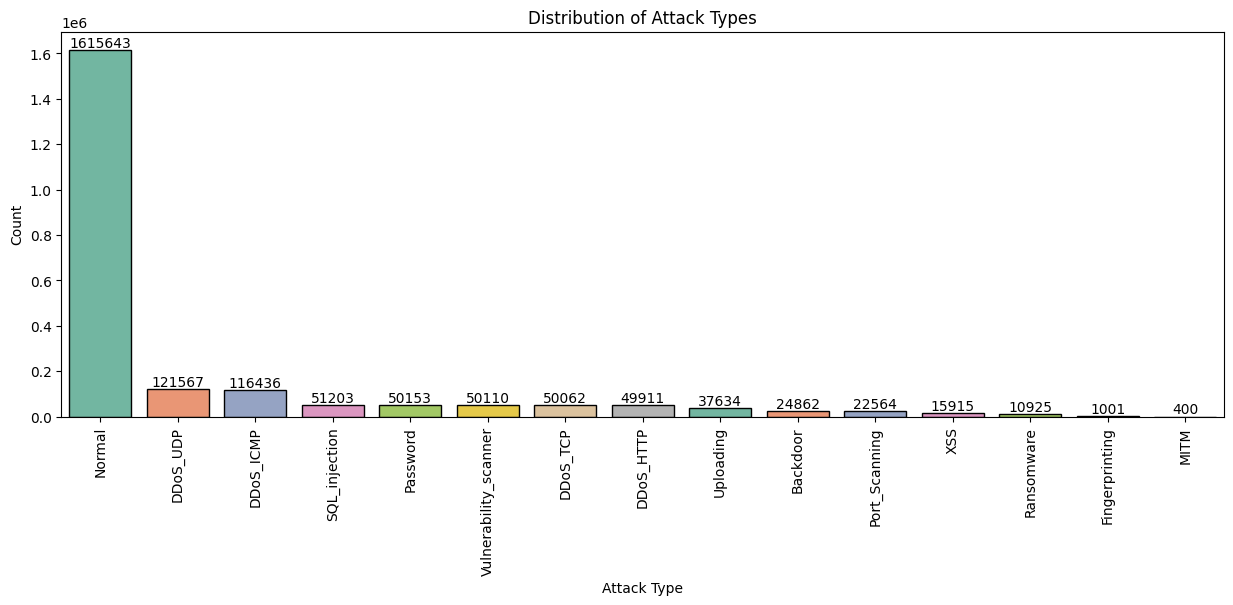

In [17]:
vc_attack_types = df["Attack_type"].value_counts()
plt.figure(figsize=(15, 5))
sns.barplot(
    x=vc_attack_types.index,
    y=vc_attack_types.values,
    hue=vc_attack_types.index, palette="Set2",
    edgecolor="black"
)
for label in vc_attack_types.index:
    plt.text(
        x=label, 
        y=vc_attack_types[label] + 5,
        s=str(vc_attack_types[label]),
        ha='center', va='bottom'
    )
plt.title("Distribution of Attack Types")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

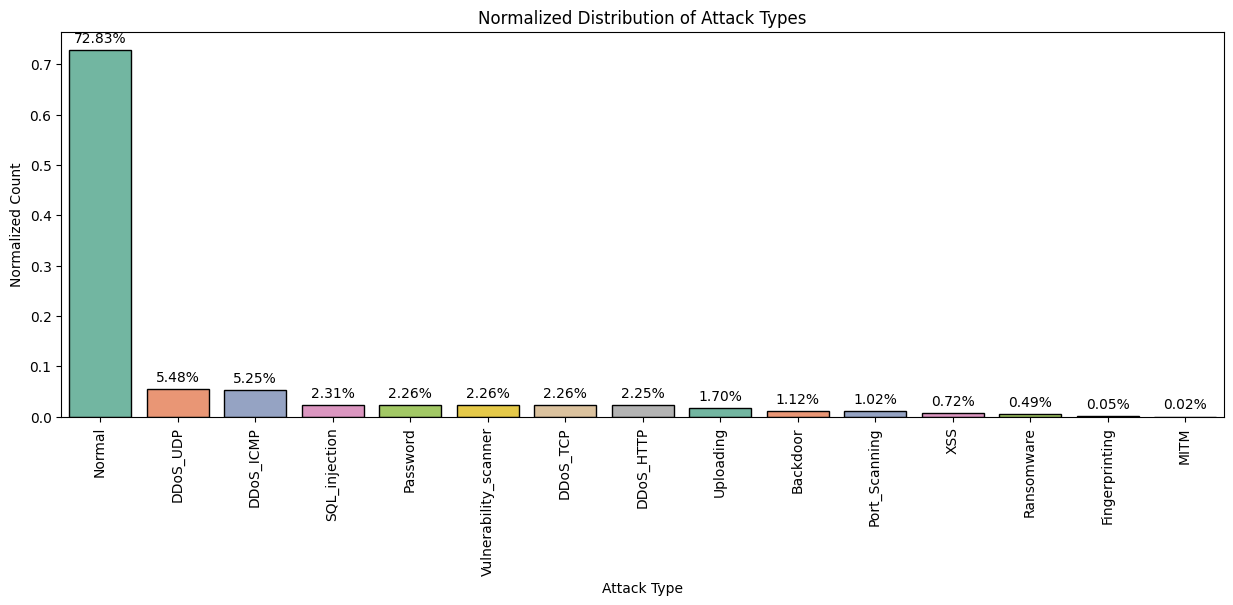

In [18]:
vc_attack_types_normalized = df["Attack_type"].value_counts(normalize=True)
plt.figure(figsize=(15, 5))
sns.barplot(
    x=vc_attack_types_normalized.index,
    y=vc_attack_types_normalized.values,
    hue=vc_attack_types_normalized.index, palette="Set2",
    edgecolor="black"
)
for label in vc_attack_types_normalized.index:
    plt.text(
        x=label, 
        y=vc_attack_types_normalized[label] + 0.01,
        s=f"{vc_attack_types_normalized[label]:.2%}",
        ha='center', va='bottom'
    )
plt.title("Normalized Distribution of Attack Types")
plt.xlabel("Attack Type")
plt.ylabel("Normalized Count")
plt.xticks(rotation=90)
plt.show()

# Feature engineering

In [19]:
y_binary = df.pop("Attack_label")
y_multi = df.pop("Attack_type")
X = df.copy()

In [20]:
X.columns

Index(['arp.opcode', 'arp.hw.size', 'icmp.checksum', 'icmp.seq_le',
       'http.content_length', 'http.request.method', 'http.referer',
       'http.request.version', 'http.response', 'tcp.ack', 'tcp.ack_raw',
       'tcp.checksum', 'tcp.connection.fin', 'tcp.connection.rst',
       'tcp.connection.syn', 'tcp.connection.synack', 'tcp.flags',
       'tcp.flags.ack', 'tcp.len', 'tcp.seq', 'udp.stream', 'udp.time_delta',
       'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu', 'dns.retransmission',
       'dns.retransmit_request', 'dns.retransmit_request_in',
       'mqtt.conack.flags', 'mqtt.conflag.cleansess', 'mqtt.conflags',
       'mqtt.hdrflags', 'mqtt.len', 'mqtt.msgtype', 'mqtt.proto_len',
       'mqtt.protoname', 'mqtt.topic', 'mqtt.topic_len', 'mqtt.ver',
       'mbtcp.len', 'mbtcp.trans_id', 'mbtcp.unit_id'],
      dtype='object')

In [21]:
X.dtypes

arp.opcode                   float64
arp.hw.size                  float64
icmp.checksum                float64
icmp.seq_le                  float64
http.content_length          float64
http.request.method           object
http.referer                  object
http.request.version          object
http.response                float64
tcp.ack                      float64
tcp.ack_raw                  float64
tcp.checksum                 float64
tcp.connection.fin           float64
tcp.connection.rst           float64
tcp.connection.syn           float64
tcp.connection.synack        float64
tcp.flags                    float64
tcp.flags.ack                float64
tcp.len                      float64
tcp.seq                      float64
udp.stream                   float64
udp.time_delta               float64
dns.qry.name                 float64
dns.qry.name.len              object
dns.qry.qu                   float64
dns.retransmission           float64
dns.retransmit_request       float64
d

In [22]:
# Separate numerical and categorical features for further analysis
num_features_df = X.select_dtypes(include=[np.number])
cat_features_df = X.select_dtypes(exclude=[np.number])

In [23]:
cat_features_df.head()

,http.request.method,http.referer,http.request.version,dns.qry.name.len,mqtt.conack.flags,mqtt.protoname,mqtt.topic
0,0.0,0.0,0.0,0,0,0,0
1,0.0,0.0,0.0,0,0,MQTT,0
2,0.0,0.0,0.0,0,0,0,0
3,0.0,0.0,0.0,0,0x00000000,0,0
4,0.0,0.0,0.0,0,0,0,Temperature_and_Humidity


In [24]:
# Check most frequent values in categorical features
for col in cat_features_df.columns:
    print(cat_features_df[col].value_counts().head(10))
    print("\n\n")

http.request.method
0.0         1963460
0            222839
GET           30474
POST           1212
TRACE           387
OPTIONS           6
PROPFIND          4
PUT               2
SEARCH            2
Name: count, dtype: int64



http.referer
0.0                                                                     2102450
0                                                                        115366
127.0.0.1                                                                   383
() { _; } >_[$($())] { echo 93e4r0-CVE-2014-6278: true; echo;echo; }        185
TESTING_PURPOSES_ONLY                                                         2
Name: count, dtype: int64



http.request.version
0.0                                                                                1963060
0                                                                                   223239
HTTP/1.1                                                                             28682
HTTP/1.0                           

In [25]:
# Replace 0.0 and 0 with "unknown" in categorical features
cat_features_df = cat_features_df.copy()
for col in cat_features_df.columns:
    cat_features_df[col] = cat_features_df[col].replace(["0.0", "0"], "unknown")

# Replace special characters in categorical features
pattern = r"[^A-Za-z0-9_]+"
for col in cat_features_df.columns:
    cat_features_df[col] = (
        cat_features_df[col].astype(str).str.replace(pattern, "_", regex=True)
    )

In [26]:
cat_features_df.head(50)

,http.request.method,http.referer,http.request.version,dns.qry.name.len,mqtt.conack.flags,mqtt.protoname,mqtt.topic
0,unknown,unknown,unknown,unknown,unknown,unknown,unknown
1,unknown,unknown,unknown,unknown,unknown,MQTT,unknown
2,unknown,unknown,unknown,unknown,unknown,unknown,unknown
3,unknown,unknown,unknown,unknown,0x00000000,unknown,unknown
4,unknown,unknown,unknown,unknown,unknown,unknown,Temperature_and_Humidity
5,unknown,unknown,unknown,unknown,unknown,unknown,unknown
6,unknown,unknown,unknown,unknown,unknown,unknown,unknown
7,unknown,unknown,unknown,unknown,unknown,unknown,unknown
8,unknown,unknown,unknown,unknown,unknown,unknown,unknown
9,unknown,unknown,unknown,unknown,unknown,unknown,unknown


In [27]:
# One-hot encoding of categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cat_features = encoder.fit_transform(cat_features_df)

# Convert encoded features back to DataFrame
encoded_cat_features_df = pd.DataFrame(
    encoded_cat_features,
    columns=encoder.get_feature_names_out(cat_features_df.columns),
    index=cat_features_df.index
)

In [28]:
encoded_cat_features_df.head()

,http.request.method_GET,http.request.method_OPTIONS,http.request.method_POST,http.request.method_PROPFIND,http.request.method_PUT,http.request.method_SEARCH,http.request.method_TRACE,http.request.method_unknown,http.referer_127_0_0_1,http.referer_TESTING_PURPOSES_ONLY,...,mqtt.conack.flags_1461591,mqtt.conack.flags_1471198,mqtt.conack.flags_1471199,mqtt.conack.flags_1574358,mqtt.conack.flags_1574359,mqtt.conack.flags_unknown,mqtt.protoname_MQTT,mqtt.protoname_unknown,mqtt.topic_Temperature_and_Humidity,mqtt.topic_unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [29]:
# Merge numerical and encoded categorical features back
X = pd.concat([num_features_df, encoded_cat_features_df], axis=1)
X.shape

(2218386, 84)

# Train-test split binary

In [30]:
# Split the dataset into training (0.6), validation (0.2), and test sets (0.2)
X_train, X_temp, y_train_binary, y_temp = train_test_split(
    X, y_binary, test_size=0.4, random_state=42, stratify=y_binary
)

X_val, X_test, y_val_binary, y_test_binary = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [31]:
X_train.shape, X_val.shape, X_test.shape

((1331031, 84), (443677, 84), (443678, 84))

In [32]:
print(y_train_binary.value_counts())
print("\n\n")
print(y_val_binary.value_counts())
print("\n\n")
print(y_test_binary.value_counts())

Attack_label
0    969385
1    361646
Name: count, dtype: int64



Attack_label
0    323129
1    120548
Name: count, dtype: int64



Attack_label
0    323129
1    120549
Name: count, dtype: int64


In [33]:
print(y_train_binary.value_counts(normalize=True))
print("\n\n")
print(y_val_binary.value_counts(normalize=True))
print("\n\n")
print(y_test_binary.value_counts(normalize=True))

Attack_label
0    0.728296
1    0.271704
Name: proportion, dtype: float64



Attack_label
0    0.728298
1    0.271702
Name: proportion, dtype: float64



Attack_label
0    0.728296
1    0.271704
Name: proportion, dtype: float64


# [Helpers]

In [34]:
def plot_cm_binary(y_true, y_pred):
    """Helper function to plot confusion matrix for binary classification."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", ax=ax[0])
    ax[0].set_title("Normalized Confusion Matrix")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("True")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
    ax[1].set_title("Confusion Matrix")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("True")
    
    return fig, ax

In [35]:
def plot_feature_importances(model, feature_names, n):
    """Helper function to plot feature importances from a model."""
    importances = model.feature_importances_
    idx = np.argsort(importances)[-n:]
    top_names = feature_names[idx]
    top_imps = importances[idx]

    order = np.argsort(top_imps)
    top_names, top_imps = top_names[order], top_imps[order]

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.barh(top_names, top_imps)
    ax.set_xlabel("Importance score")
    title = f"Top {n} Feature Importances"
    ax.set_title(title)
    fig.tight_layout()

    return fig, ax

# Binary classification with Random Forest

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    323129
           1       0.96      0.91      0.93    120548

    accuracy                           0.96    443677
   macro avg       0.96      0.95      0.95    443677
weighted avg       0.96      0.96      0.96    443677




tp: 109257
fp: 4710
fn: 11291
tn: 318419
accuracy: 0.9639354755824621
precision: 0.9586722472294612
recall: 0.9063360653017885
f1: 0.931769822825832
balanced_accuracy: 0.9458799217106815


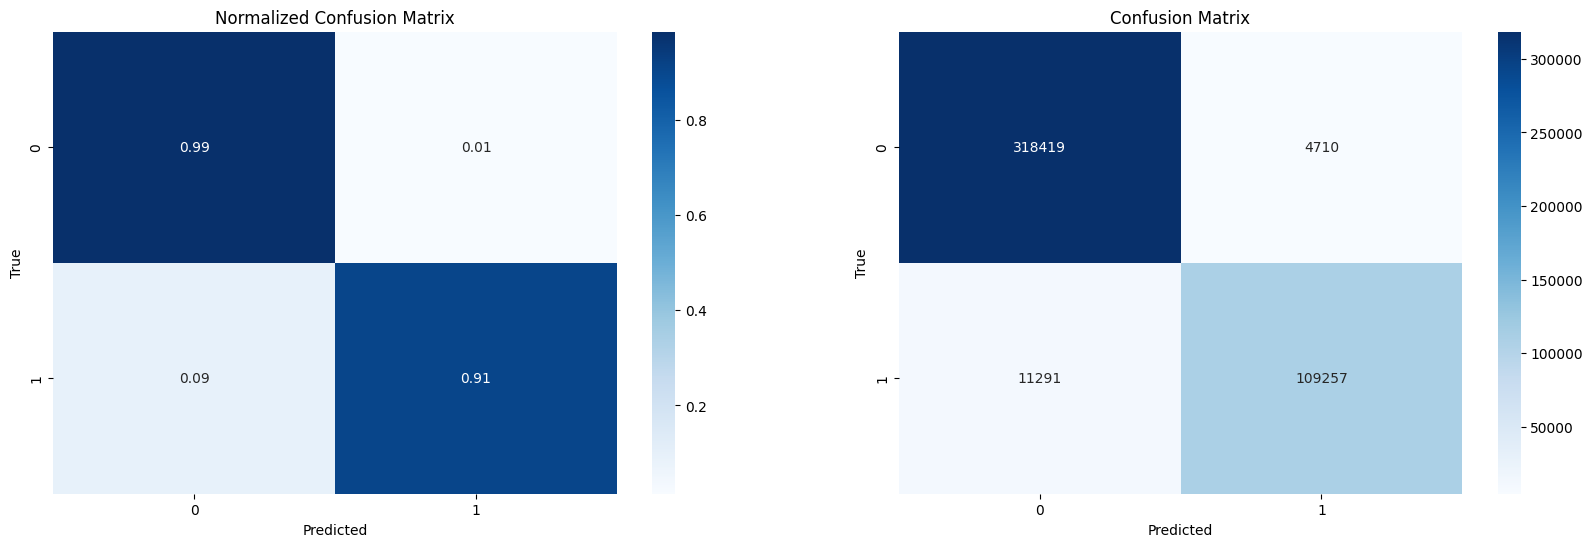

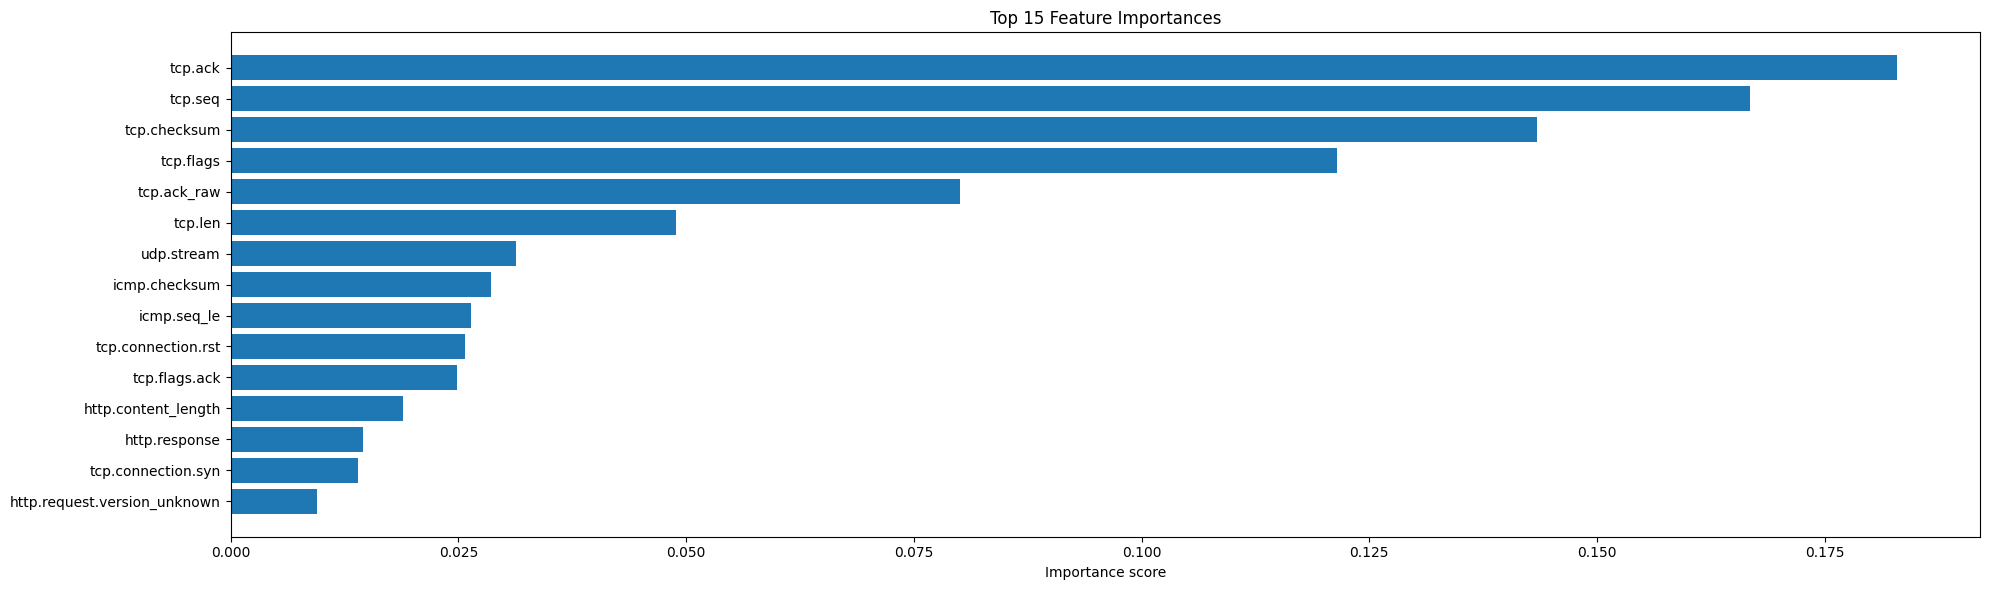

🏃 View run RandomForestBinaryClassification at: http://localhost:5000/#/experiments/1/runs/1970b7014da24ff38d37a54025e816a0
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [36]:
with mlflow.start_run(tags={"mlflow.runName": "RandomForestBinaryClassification"}):
    # Random Forest Classifier
    rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_classifier.fit(X_train, y_train_binary)
    y_pred_rf_binary = rf_classifier.predict(X_val)
    print(classification_report(y_val_binary, y_pred_rf_binary))
    print("\n\n")

    # Log model parameters
    mlflow.log_params(rf_classifier.get_params())
    
    # Log metrics
    metrics = get_metrics_binary(y_val_binary, y_pred_rf_binary)
    for key, value in metrics.items():
        print(f"{key}: {value}")
    mlflow.log_metrics(metrics)
    
    # Log confusion matrix
    fig, ax = plot_cm_binary(y_val_binary, y_pred_rf_binary)
    plt.show()
    mlflow.log_figure(fig, "confusion_matrix_rf.png")
    
    # Log feature importances
    fig, ax = plot_feature_importances(rf_classifier, X_train.columns, n=15)
    plt.show()
    mlflow.log_figure(fig, "feature_importances_rf.png")

    # Log model type
    mlflow.log_param("model_type", "RF-binary")

# Binary classification with XGBoost

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    323129
           1       1.00      0.89      0.94    120548

    accuracy                           0.97    443677
   macro avg       0.98      0.94      0.96    443677
weighted avg       0.97      0.97      0.97    443677




tp: 107253
fp: 80
fn: 13295
tn: 323049
accuracy: 0.9698541957324811
precision: 0.9992546560703605
recall: 0.8897119819490991
f1: 0.9413070857157902
balanced_accuracy: 0.9447322014044397


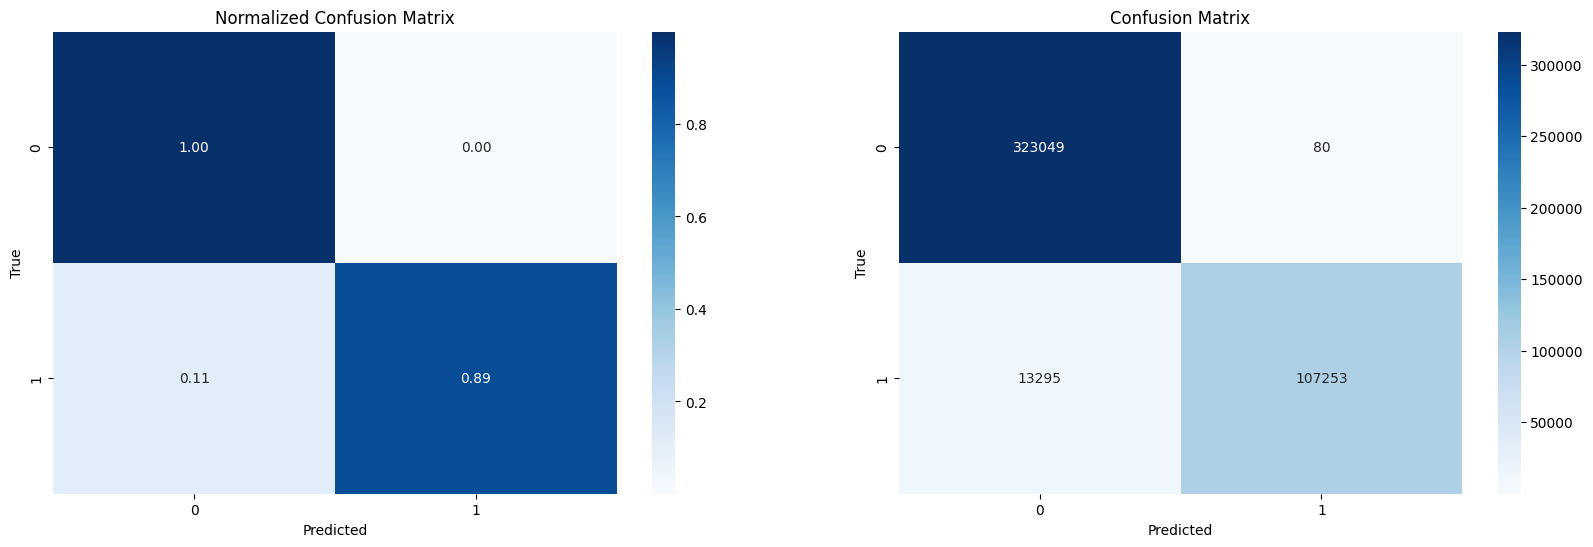

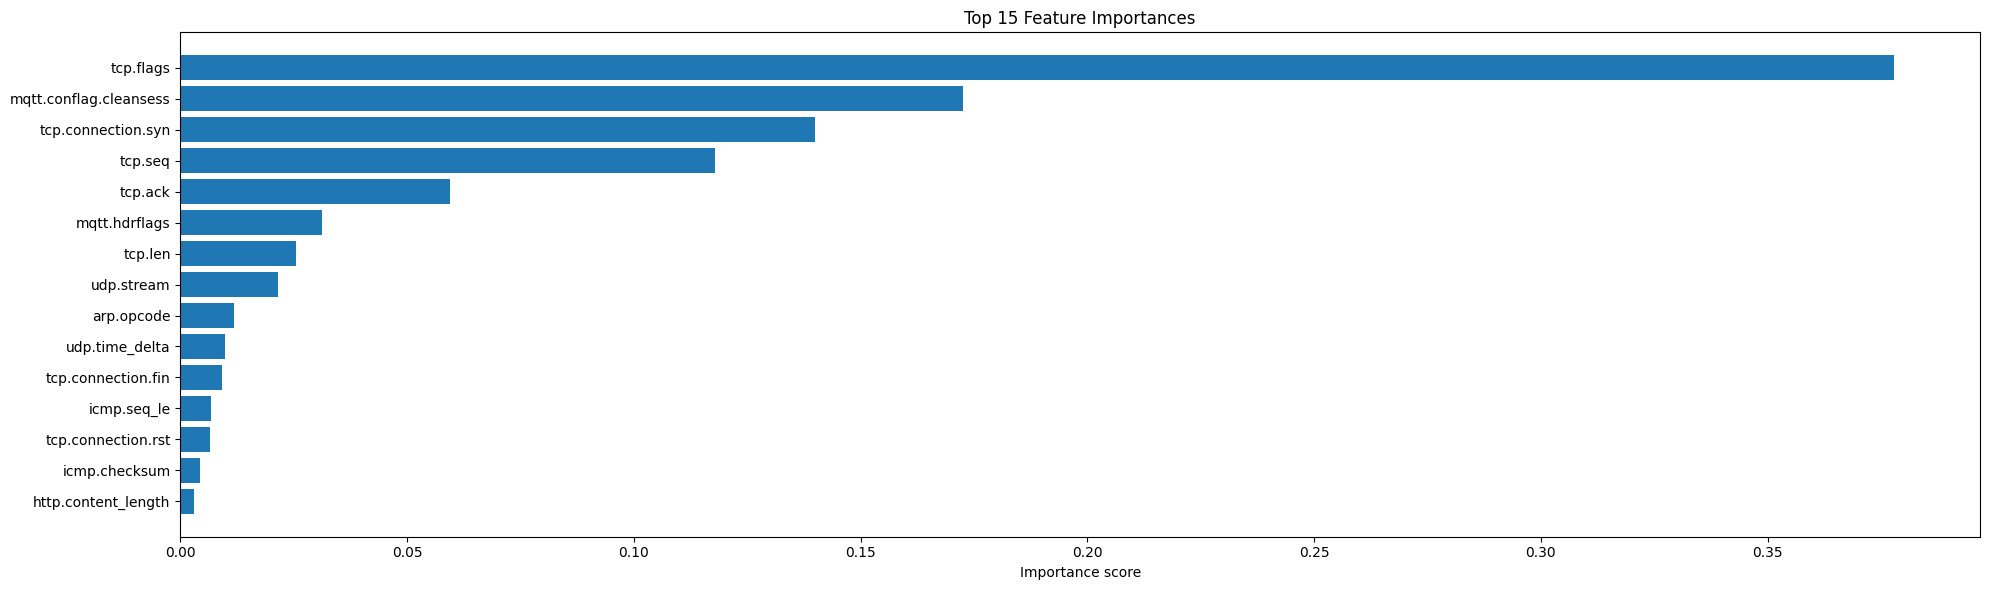

🏃 View run XGBoostBinaryClassification at: http://localhost:5000/#/experiments/1/runs/418864bafca64136889255e9df131ea1
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [37]:
with mlflow.start_run(tags={"mlflow.runName": "XGBoostBinaryClassification"}):
    # XGBoost Classifier
    xgb_classifier = xgb.XGBClassifier(random_state=42)
    xgb_classifier.fit(X_train, y_train_binary)
    y_pred_xgb_binary = xgb_classifier.predict(X_val)
    print(classification_report(y_val_binary, y_pred_xgb_binary))
    print("\n\n")
    
    # Log model parameters
    mlflow.log_params(xgb_classifier.get_params())
    
    # Log metrics
    metrics = get_metrics_binary(y_val_binary, y_pred_xgb_binary)
    for key, value in metrics.items():
        print(f"{key}: {value}")
    mlflow.log_metrics(metrics)
    
    # Log confusion matrix
    fig, ax = plot_cm_binary(y_val_binary, y_pred_xgb_binary)
    plt.show()
    mlflow.log_figure(fig, "confusion_matrix_xgb.png")

    # Log feature importances
    fig, ax = plot_feature_importances(xgb_classifier, X_train.columns, n=15)
    plt.show()
    mlflow.log_figure(fig, "feature_importances_xgb.png")

    # Log model type
    mlflow.log_param("model_type", "XGB-binary")

# Train-test split for multi-class classification

In [38]:
# Split the dataset into training (0.6), validation (0.2), and test sets (0.2)
X_train, X_temp, y_train_multi, y_temp = train_test_split(
    X, y_multi, test_size=0.4, random_state=42, stratify=y_multi
)

X_val, X_test, y_val_multi, y_test_multi = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [39]:
X_train.shape, X_val.shape, X_test.shape

((1331031, 84), (443677, 84), (443678, 84))

In [40]:
print(y_train_multi.value_counts())
print("\n\n")
print(y_val_multi.value_counts())
print("\n\n")
print(y_test_multi.value_counts())

Attack_type
Normal                   969385
DDoS_UDP                  72940
DDoS_ICMP                 69862
SQL_injection             30722
Password                  30092
Vulnerability_scanner     30066
DDoS_TCP                  30037
DDoS_HTTP                 29947
Uploading                 22580
Backdoor                  14917
Port_Scanning             13538
XSS                        9549
Ransomware                 6555
Fingerprinting              601
MITM                        240
Name: count, dtype: int64



Attack_type
Normal                   323129
DDoS_UDP                  24313
DDoS_ICMP                 23287
SQL_injection             10240
Password                  10030
Vulnerability_scanner     10022
DDoS_TCP                  10013
DDoS_HTTP                  9982
Uploading                  7527
Backdoor                   4973
Port_Scanning              4513
XSS                        3183
Ransomware                 2185
Fingerprinting              200
MITM               

In [41]:
print(y_train_multi.value_counts(normalize=True))
print("\n\n")
print(y_val_multi.value_counts(normalize=True))
print("\n\n")
print(y_test_multi.value_counts(normalize=True))

Attack_type
Normal                   0.728296
DDoS_UDP                 0.054800
DDoS_ICMP                0.052487
SQL_injection            0.023081
Password                 0.022608
Vulnerability_scanner    0.022589
DDoS_TCP                 0.022567
DDoS_HTTP                0.022499
Uploading                0.016964
Backdoor                 0.011207
Port_Scanning            0.010171
XSS                      0.007174
Ransomware               0.004925
Fingerprinting           0.000452
MITM                     0.000180
Name: proportion, dtype: float64



Attack_type
Normal                   0.728298
DDoS_UDP                 0.054799
DDoS_ICMP                0.052486
SQL_injection            0.023080
Password                 0.022607
Vulnerability_scanner    0.022589
DDoS_TCP                 0.022568
DDoS_HTTP                0.022498
Uploading                0.016965
Backdoor                 0.011209
Port_Scanning            0.010172
XSS                      0.007174
Ransomware            

In [42]:
# Encode string labels to numeric
label_encoder = LabelEncoder()
y_train_multi_encoded = label_encoder.fit_transform(y_train_multi)
y_val_multi_encoded = label_encoder.transform(y_val_multi)

# [Helpers]

In [43]:
def plot_cm_multiclass(y_true, y_pred, labels=None):
    """Helper function to plot confusion matrix for multiclass classification."""
    fig, ax = plt.subplots(1, 2, figsize=(40, 20))
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", ax=ax[0])
    ax[0].set_title("Normalized Confusion Matrix")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("True")
    ax[0].set_xticklabels(labels, rotation=45)
    ax[0].set_yticklabels(labels, rotation=0)

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
    ax[1].set_title("Confusion Matrix")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("True")
    ax[1].set_xticklabels(labels, rotation=45)
    ax[1].set_yticklabels(labels, rotation=0)

    return fig, ax

# Multi-class classification Random Forest

                       precision    recall  f1-score   support

             Backdoor       0.97      0.90      0.94      4973
            DDoS_HTTP       0.74      0.68      0.71      9982
            DDoS_ICMP       1.00      1.00      1.00     23287
             DDoS_TCP       1.00      1.00      1.00     10013
             DDoS_UDP       1.00      1.00      1.00     24313
       Fingerprinting       0.83      0.57      0.68       200
                 MITM       1.00      0.99      0.99        80
               Normal       0.97      0.99      0.98    323129
             Password       0.90      0.73      0.81     10030
        Port_Scanning       0.83      0.88      0.85      4513
           Ransomware       0.94      0.78      0.85      2185
        SQL_injection       0.88      0.70      0.78     10240
            Uploading       0.78      0.63      0.70      7527
Vulnerability_scanner       0.99      0.95      0.97     10022
                  XSS       0.91      0.73      0.81  

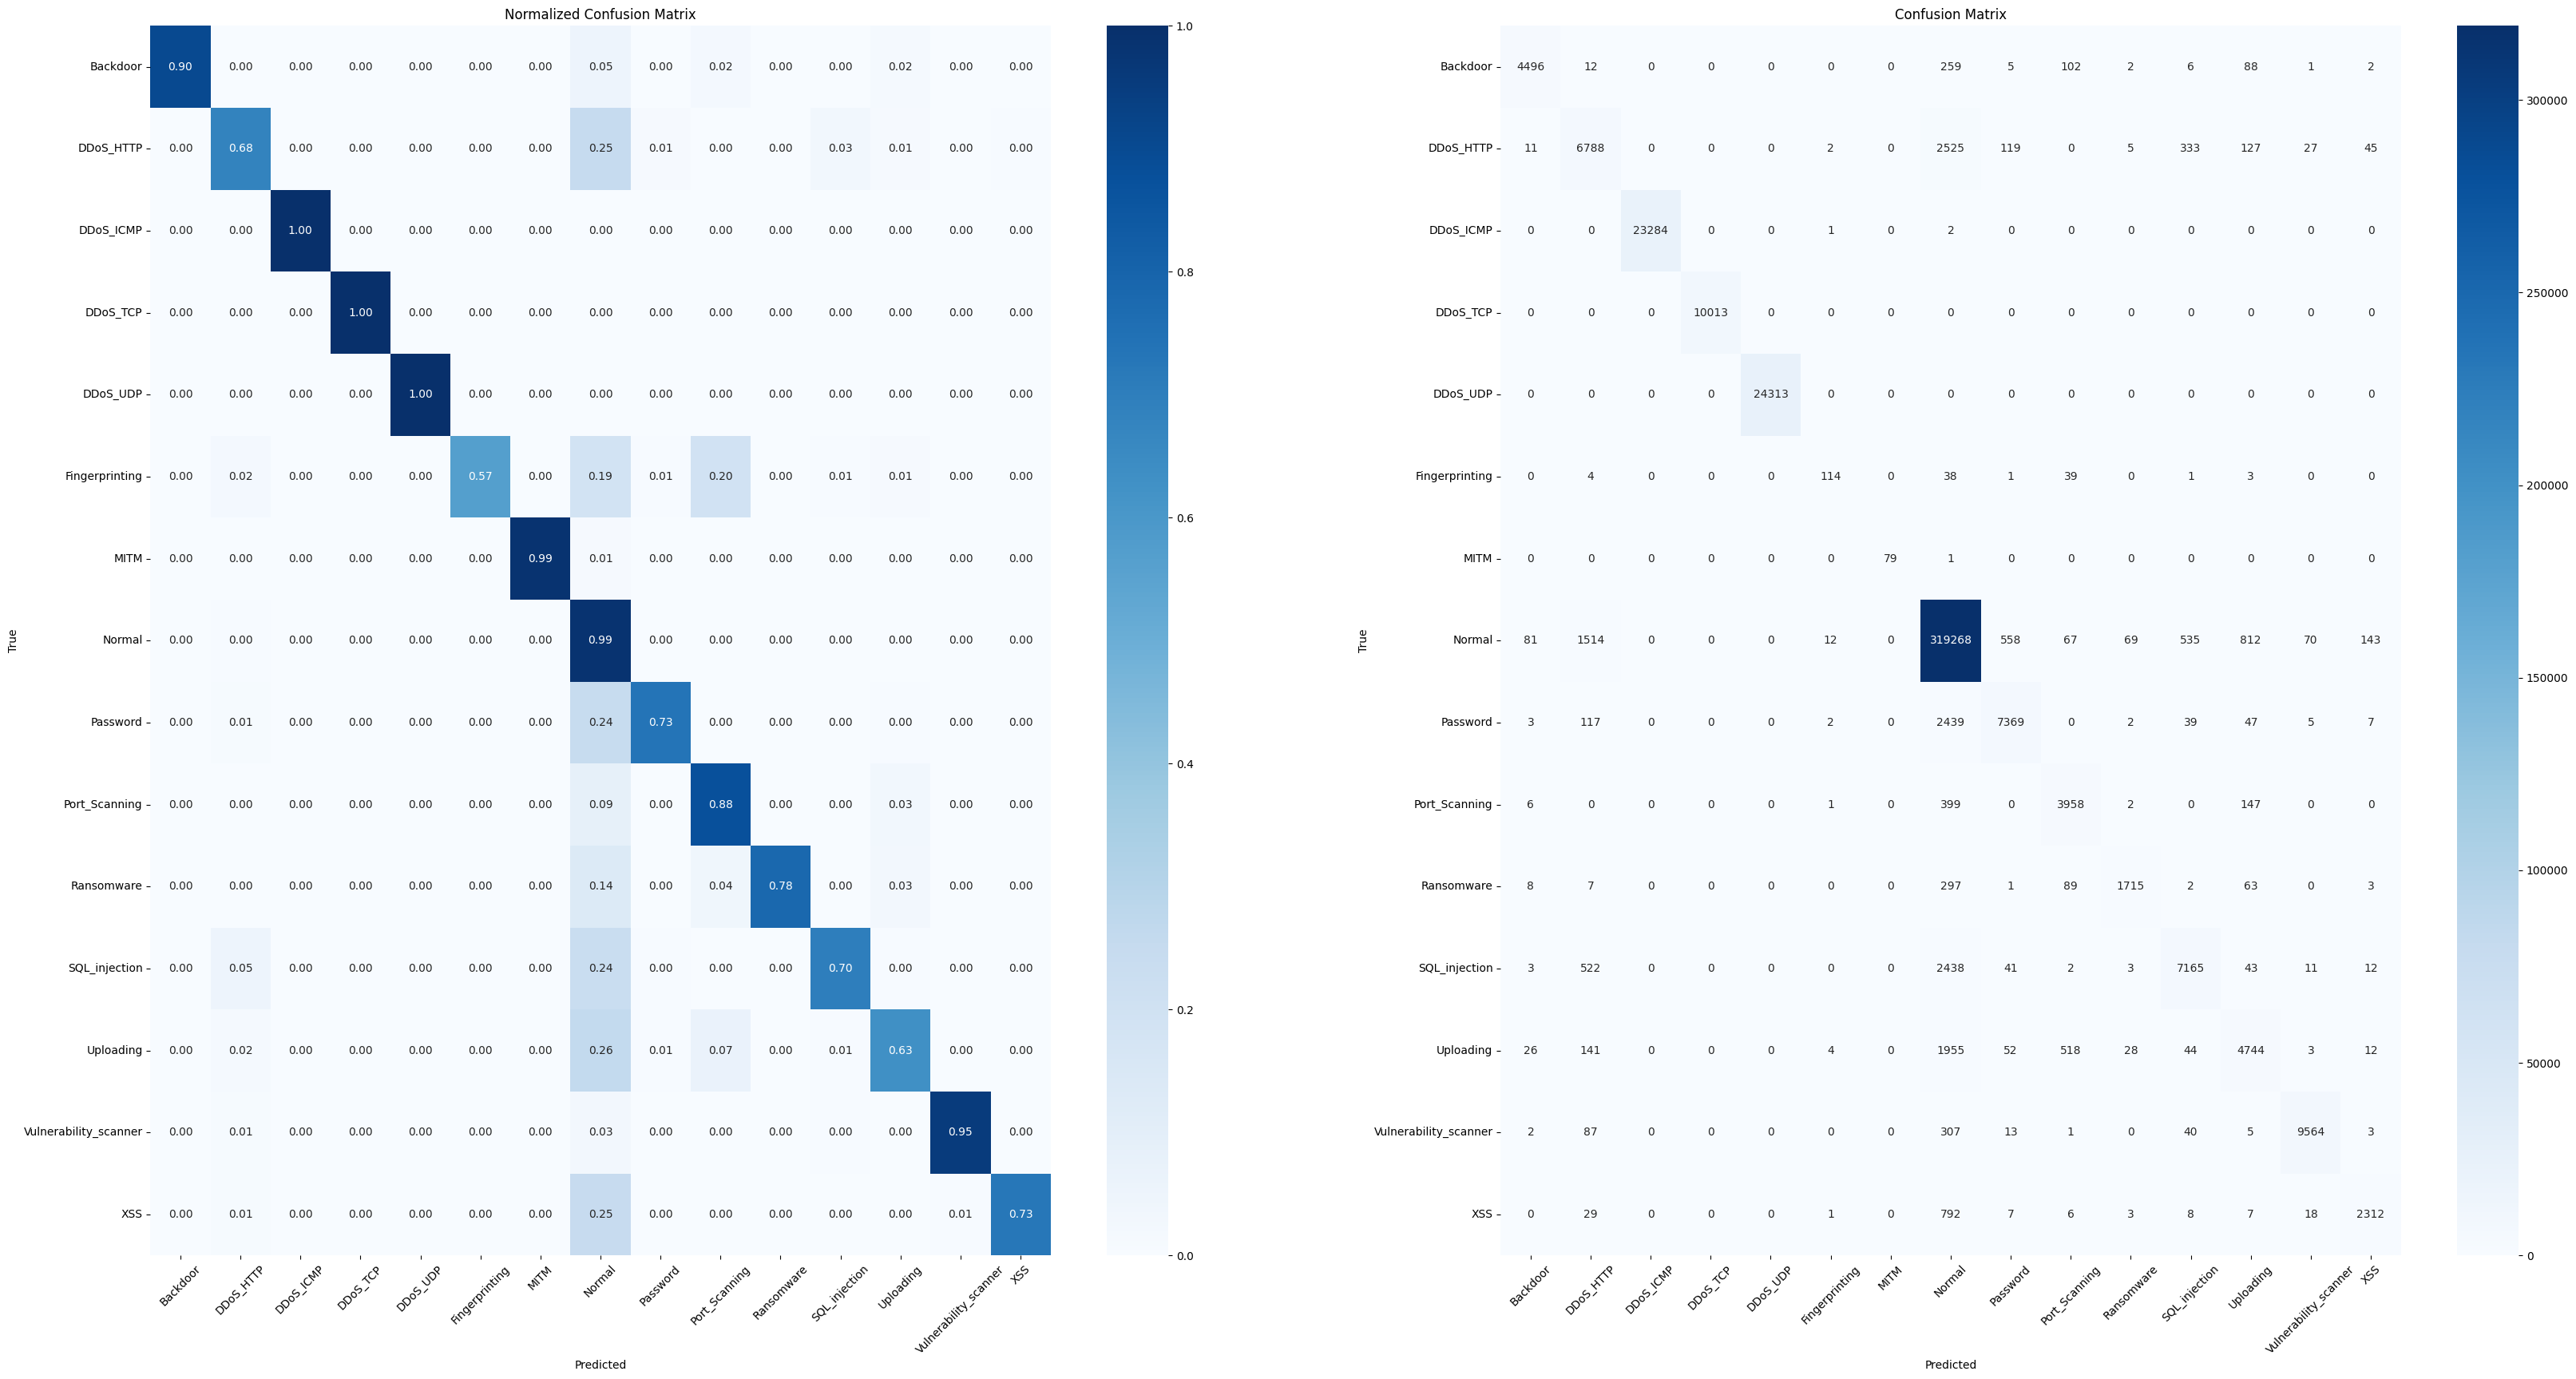

🏃 View run RandomForestMultiClassClassification at: http://localhost:5000/#/experiments/1/runs/24e198b87e9348d7bf292d5ee6a6e279
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [44]:
with mlflow.start_run(tags={"mlflow.runName": "RandomForestMultiClassClassification"}):
    # Random Forest multi-class classifier
    rf_classifier_multi = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_classifier_multi.fit(X_train, y_train_multi_encoded)    
    y_pred_rf_multi = rf_classifier_multi.predict(X_val)

    # Convert predictions and true labels back to original class names for display
    y_pred_rf_multi_names = label_encoder.inverse_transform(y_pred_rf_multi)
    y_val_multi_names = label_encoder.inverse_transform(y_val_multi_encoded)
    print(classification_report(
        y_val_multi_names, 
        y_pred_rf_multi_names,
        target_names=label_encoder.classes_
    ))
    print("\n\n")
    
    # Log model parameters
    mlflow.log_params(rf_classifier_multi.get_params())
    
    # Log metrics
    metrics = get_metrics_multiclass(
        y_val_multi_names,
        y_pred_rf_multi_names,
        average="macro"
    )
    for key, value in metrics.items():
        print(f"{key}: {value}")
    mlflow.log_metrics(metrics)
    
    # Log confusion matrix
    fig, ax = plot_cm_multiclass(
        y_val_multi_names, y_pred_rf_multi_names, labels=label_encoder.classes_
    )
    plt.show()
    mlflow.log_figure(fig, "confusion_matrix_rf_multi.png")
    
    # Log model type
    mlflow.log_param("model_type", "RF-multi)")

# Multi-class classification XGBoost

                       precision    recall  f1-score   support

             Backdoor       1.00      0.90      0.95      4973
            DDoS_HTTP       0.91      0.63      0.75      9982
            DDoS_ICMP       1.00      1.00      1.00     23287
             DDoS_TCP       1.00      1.00      1.00     10013
             DDoS_UDP       1.00      1.00      1.00     24313
       Fingerprinting       0.59      0.26      0.36       200
                 MITM       1.00      0.99      0.99        80
               Normal       0.96      1.00      0.98    323129
             Password       0.98      0.70      0.82     10030
        Port_Scanning       0.82      0.91      0.86      4513
           Ransomware       0.99      0.79      0.88      2185
        SQL_injection       0.91      0.69      0.79     10240
            Uploading       0.94      0.62      0.74      7527
Vulnerability_scanner       1.00      0.92      0.96     10022
                  XSS       0.96      0.68      0.79  

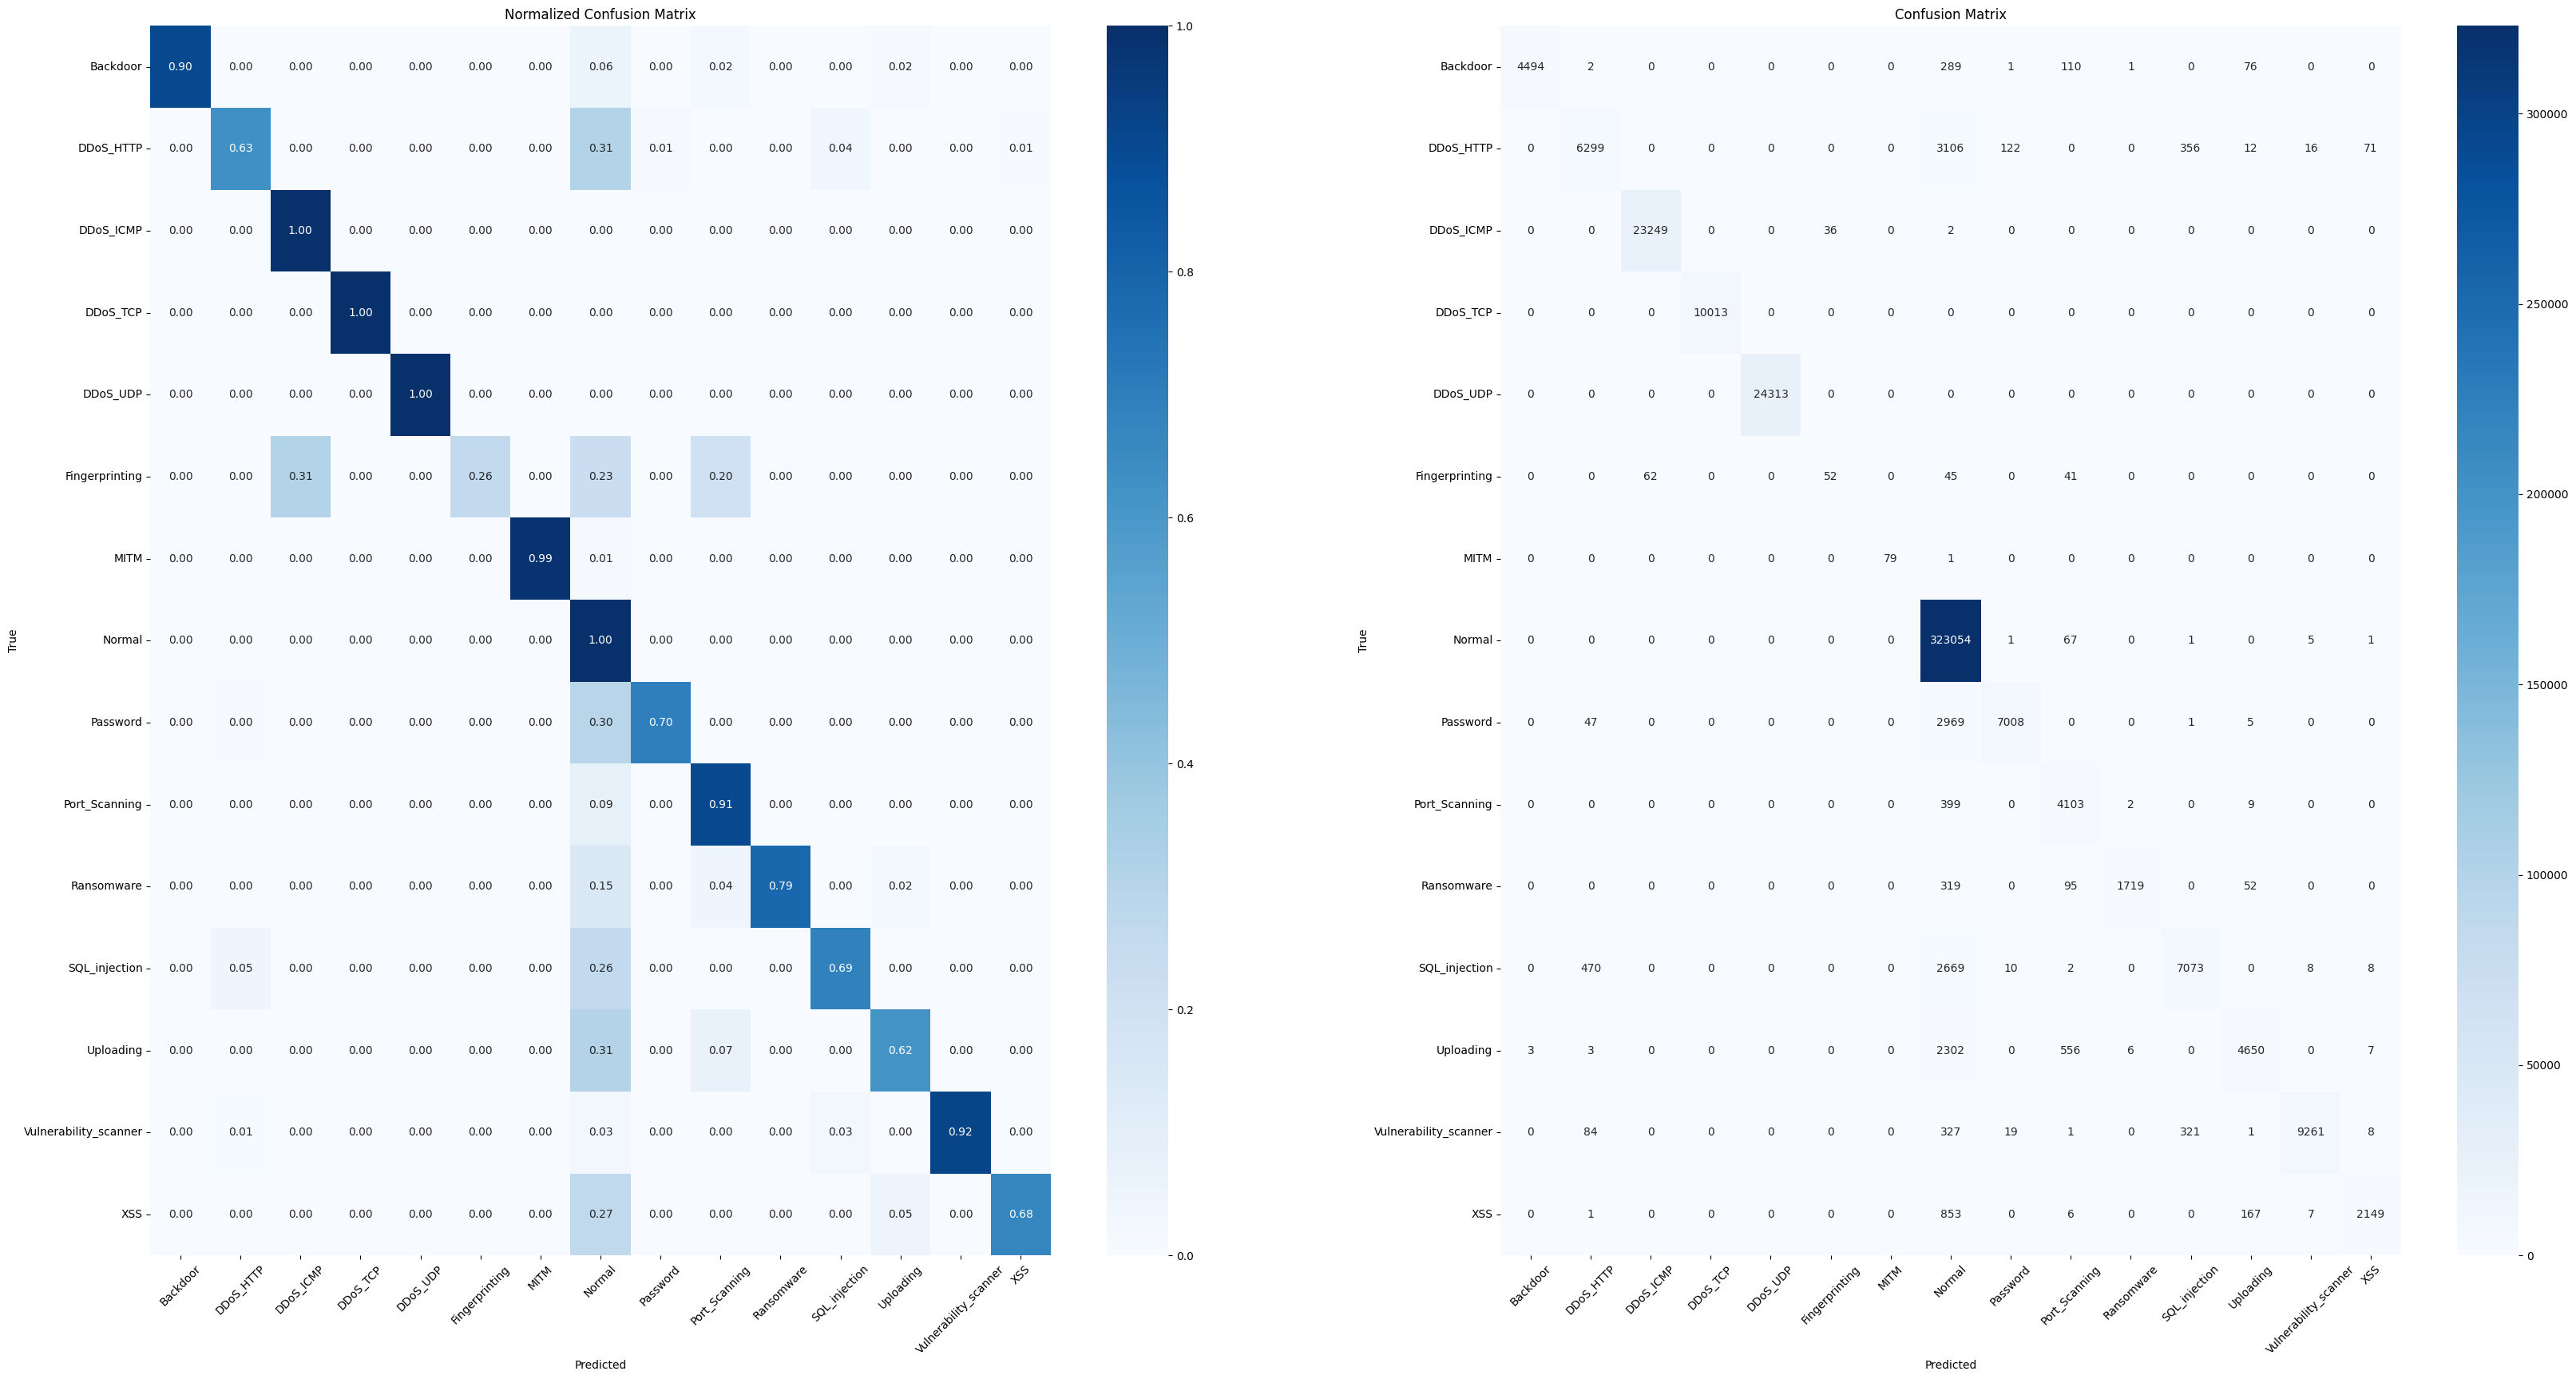

🏃 View run XGBoostMultiClassClassification at: http://localhost:5000/#/experiments/1/runs/af58a19b8d544cc7897b8350138e1a90
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [45]:
with mlflow.start_run(tags={"mlflow.runName": "XGBoostMultiClassClassification"}):
    # XGBoost multi-class classifier
    xgb_classifier_multi = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
    )
    xgb_classifier_multi.fit(X_train, y_train_multi_encoded)
    y_pred_xgb_multi = xgb_classifier_multi.predict(X_val)

    # Convert predictions back to original class names for display (true are 
    # already in original class names)
    y_pred_xgb_multi_names = label_encoder.inverse_transform(y_pred_xgb_multi)
    print(classification_report(
        y_val_multi_names, 
        y_pred_xgb_multi_names,
        target_names=label_encoder.classes_
    ))
    print("\n\n")
    
    # Log model parameters
    mlflow.log_params(xgb_classifier_multi.get_params())
    
    # Log metrics
    metrics = get_metrics_multiclass(
        y_val_multi_names,
        y_pred_xgb_multi_names,
        average="macro"
    )
    for key, value in metrics.items():
        print(f"{key}: {value}")
    mlflow.log_metrics(metrics)
    
    # Log confusion matrix
    fig, ax = plot_cm_multiclass(
        y_val_multi_names, y_pred_xgb_multi_names, labels=label_encoder.classes_
    )
    plt.show()
    mlflow.log_figure(fig, "confusion_matrix_xgb_multi.png")

    # Log model type
    mlflow.log_param("model_type", "XGB-multi)")

# Summary
- All tested models performed very well in both problems binary and multiclass classification. 
- In multiclass, RF performed slightly better, mainly because it handled better the minority class (Fingerprint with 200 examples). 
- However, 15 class classification problem is more computionally demanding, so for the demonstration the **binary problem will be further investigated**

- In the binary classification the key trade-off is the classic one between amount of false-positives and missed detections. This is a common \
problem in all anomaly detection tasks. For this study I assume that having less false alarms is more preferred. 
- Concluding, the **XGB** which produces orders of magnitude fewer false positives will be further explored with hyperparameter optimization and final deployment.
- Hyperparameter optimization will target to improve recall
- After training, adjustment on the decision threshold on predict_proba is also possible